# Prompt

## Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

## The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals.  

From the dataset documentation [here](https://www.openml.org/d/534):

> The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership.

## Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

# Imports

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [4]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [5]:
df.loc[:, df.dtypes == "category"].nunique()

SOUTH         2
SEX           2
UNION         2
RACE          3
OCCUPATION    6
SECTOR        3
MARR          2
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


# Model Prep

## Feature and Frame Naming

### Features

In [7]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

### Frames

In [8]:
X = df.drop(columns=target_feature)
y = df[target_feature].apply(np.log)

<Axes: >

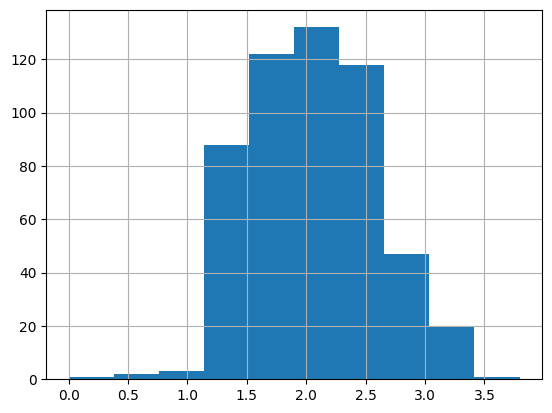

In [9]:
y.hist()

## Train & Development Split

In [10]:
(X_train, X_dev, y_train, y_dev, train_inds, dev_inds) = train_test_split(
    X, y, range(len(df)), random_state=42, train_size=0.75
)

X_train.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
204,16,no,female,6,not_member,28,White,Management,Manufacturing,Married
196,16,no,female,26,not_member,48,White,Management,Other,Married
510,17,no,female,14,not_member,37,White,Professional,Other,Married
19,12,no,male,33,not_member,51,White,Other,Other,Married
361,16,no,male,21,not_member,43,White,Service,Other,Married


# Pipeline Definition

Make a processing pipeline with the following steps:
- Column Transformer
    - Polynomial Features
    - One hot encoder
- Ridge regression

## Column Transformer

In [11]:
xformer = make_column_transformer(
    (
        PolynomialFeatures(include_bias=False),
        numeric_features,
    ),
    (
        OneHotEncoder(drop="if_binary"),
        one_hot_features,
    ),
)

In [12]:
# xformer.get_params()["transformers"][0][1].degree

## Pipeline

In [13]:
regression_pipe = Pipeline(
    [
        ("transformer", xformer),
        ("regression", Ridge(fit_intercept=True)),
    ]
).fit(X_train, y_train)

regression_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('regression', Ridge())])

In [14]:
y_train_pred = regression_pipe.predict(X_train)
mse_all_defaults = mean_squared_error(y_train_pred, y_train)

# Grid Search for Polynomial Degree and Alpha

## Search Space Definition

In [15]:
alpha_list = 10 ** np.linspace(-5, 5, 51)
degree_list = range(1, 4)
param_grid = {
    "regression__alpha": alpha_list,
    "transformer__polynomialfeatures__degree": degree_list,
}
# param_grid

## Run the Search

In [16]:
grid_search = GridSearchCV(
    estimator=regression_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

## Get Scores as Data Frame

In [17]:
results_df = pd.DataFrame(grid_search.cv_results_["params"]).join(
    pd.DataFrame({"mean_test_score": grid_search.cv_results_["mean_test_score"]})
)

results_df.head()

,regression__alpha,transformer__polynomialfeatures__degree,mean_test_score
0,0.000010,1,-0.185014
1,0.000010,2,-0.176121
2,0.000010,3,-0.174805
3,0.000016,1,-0.185014
4,0.000016,2,-0.176121


In [18]:
# grid_search.best_params_

In [19]:
# grid_search.cv_results_.keys()

## Plot Scores vs. Hyperparameter Grid

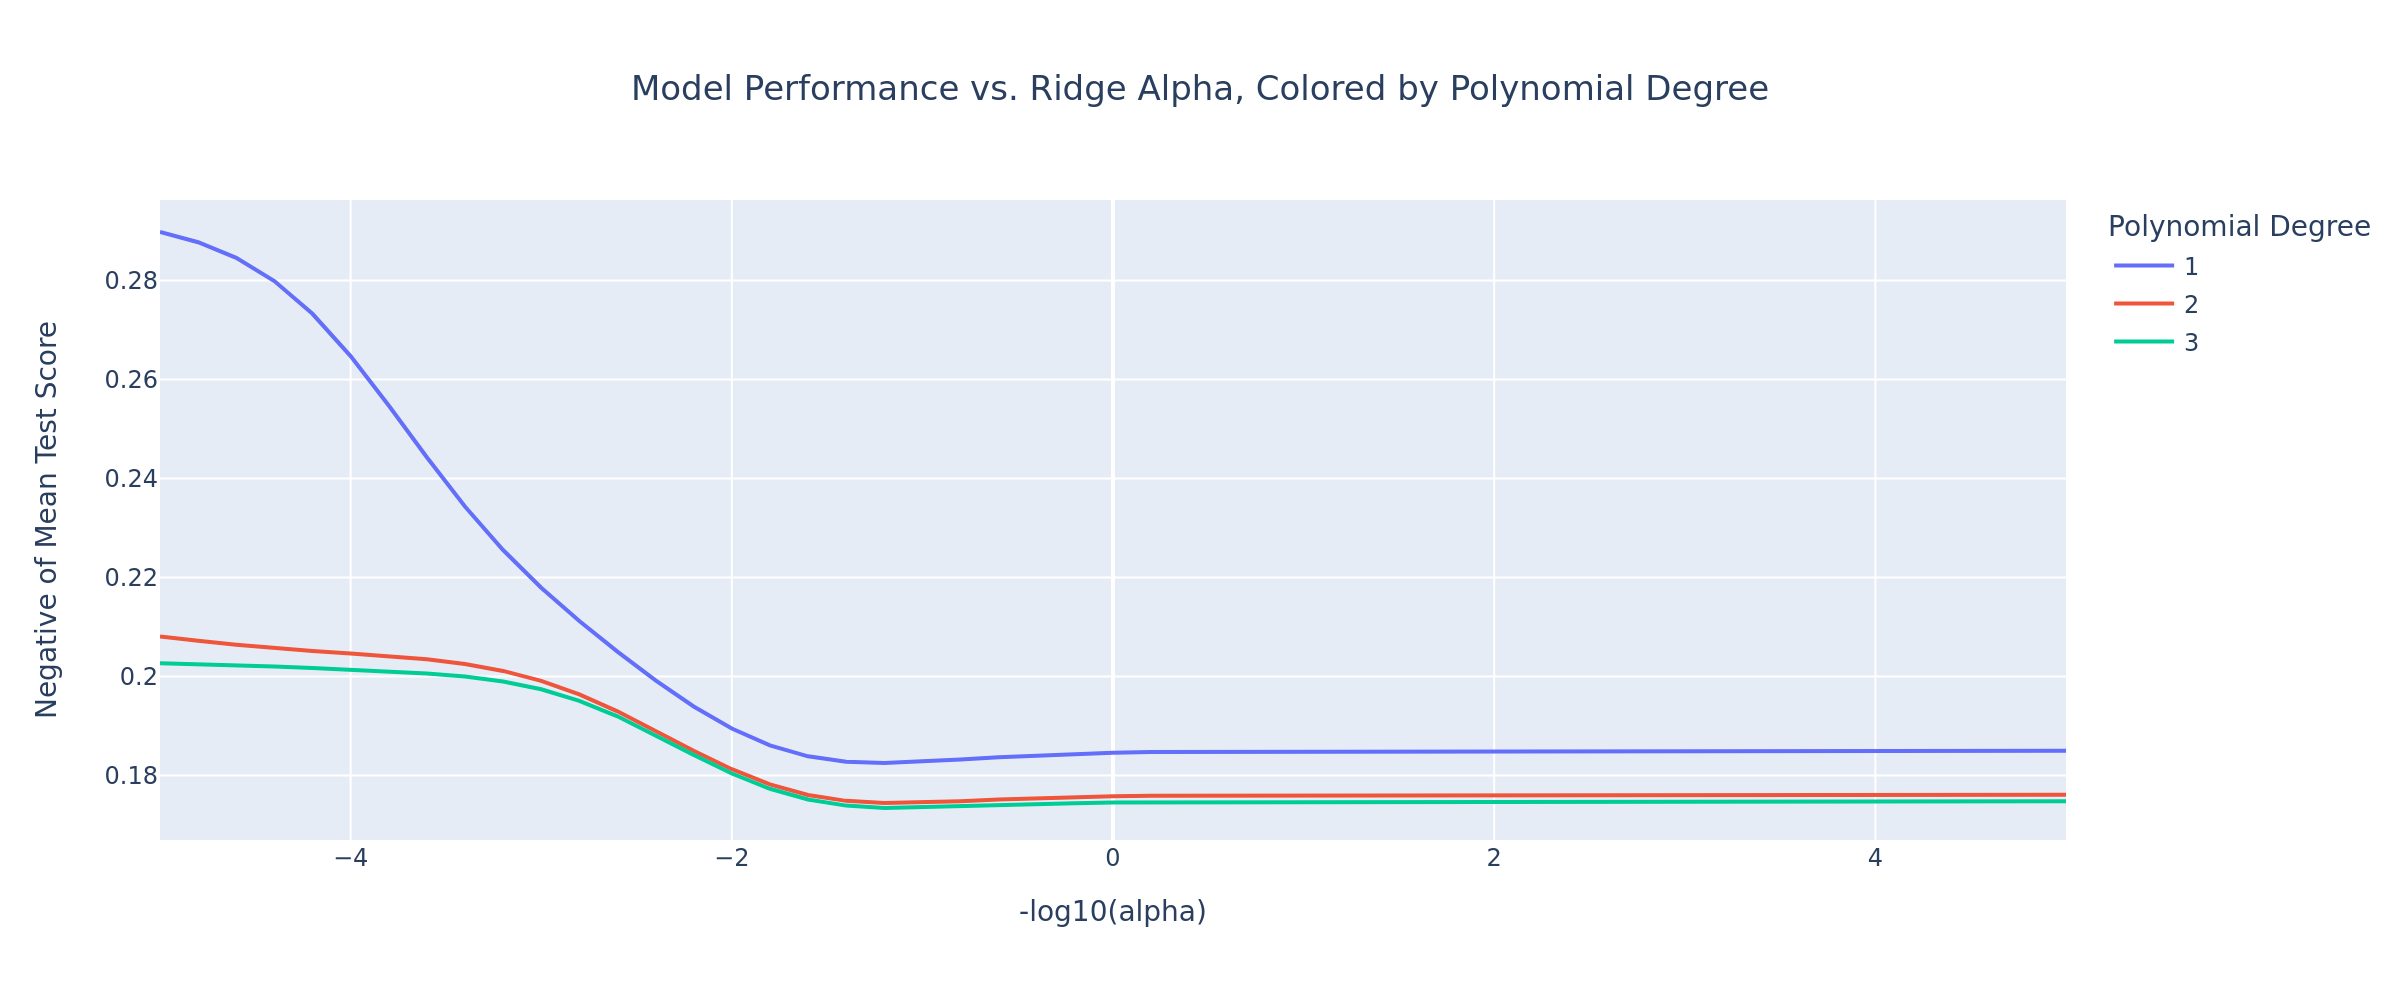

In [30]:
fig = px.line(
    results_df,
    x=-np.log10(results_df["regression__alpha"]),
    y=-results_df["mean_test_score"],
    labels={
        "x": "-log10(alpha)",
        "y": "Negative of Mean Test Score",
        "transformer__polynomialfeatures__degree": "Polynomial Degree",
    },
    title="Model Performance vs. Ridge Alpha, Colored by Polynomial Degree",
    color="transformer__polynomialfeatures__degree",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [21]:
regression_pipe.named_steps["transformer"].transformers_[0][1].degree

2

## Get the Best Model

In [25]:
regression_pipe_best = grid_search.best_estimator_.fit(X_train, y_train)
y_train_pred_best = regression_pipe_best.predict(X_train)
mse_best = mean_squared_error(y_train_pred_best, y_train)
regression_pipe_best

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('regression', Ridge(alpha=15.848931924611142))])

# Compare All Default to Best Pipeline

## Scatter with Basic and Best Estimators

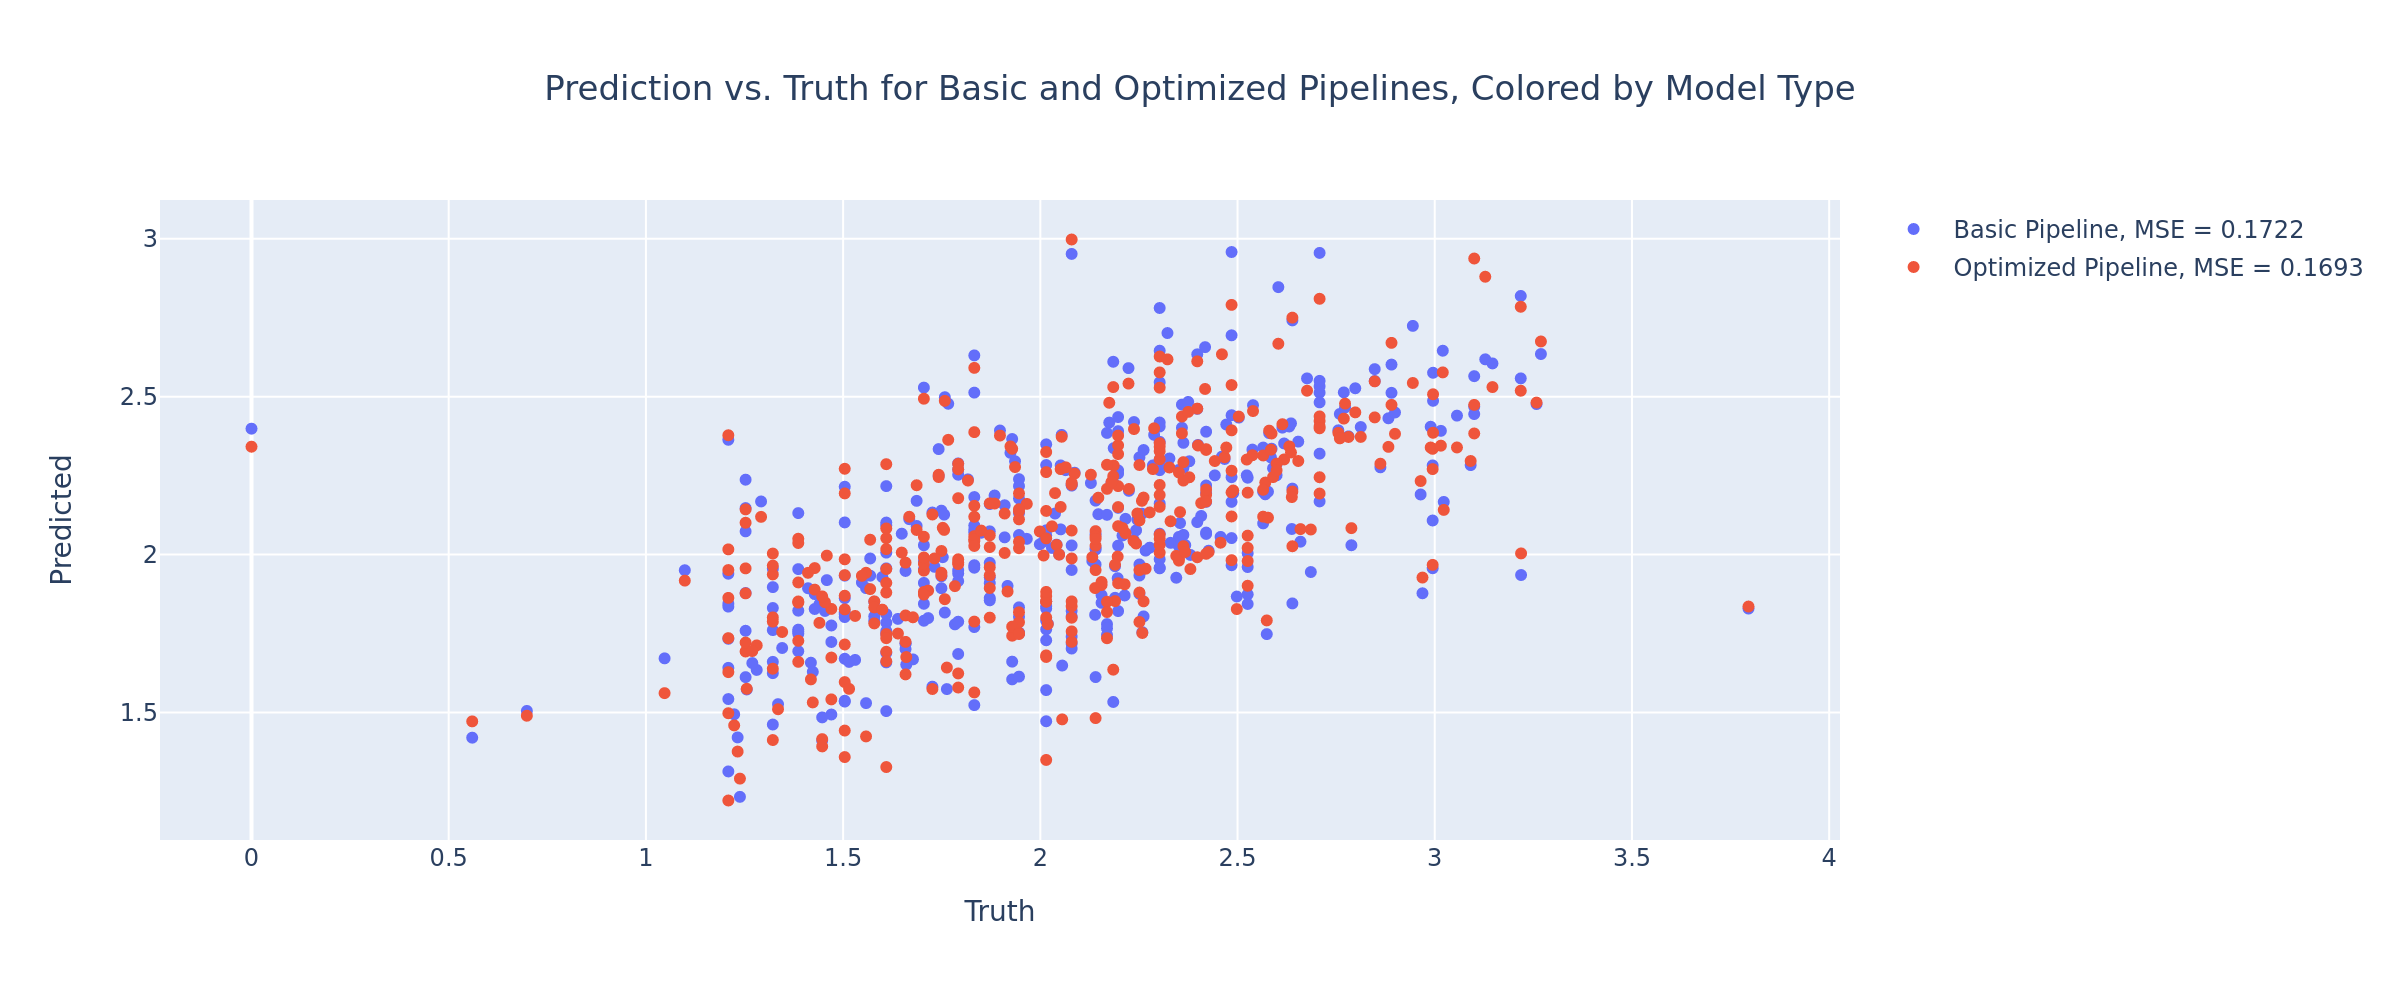

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y_train,
        y=y_train_pred,
        mode="markers",
        name="Basic Pipeline, MSE = %.4f" % mse_all_defaults,
    )
)
fig.add_trace(
    go.Scatter(
        x=y_train,
        y=y_train_pred_best,
        mode="markers",
        name="Optimized Pipeline, MSE = %.4f" % mse_best,
    )
)

fig.update_layout(
    title="Prediction vs. Truth for Basic and Optimized Pipelines, Colored by Model Type",
    xaxis_title="Truth",
    yaxis_title="Predicted",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [24]:
# sns.kdeplot(y, fill=True)

# Feature Importance